# PyTorch and CIFAR10 data analysis

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [3]:
sns.set_theme(style='white', palette='pastel')

In [4]:
DATA_DIRS = {
    'all cores': os.path.join('csv', 'torchskeleton-defworker', '2021-11-18-08-24-17-gpu'),
    'cores 1, 3 - no hyper': os.path.join('csv', 'torchskeleton-defworker', '2021-11-18-10-17-15-core1,3-nohyper'),
    'core 1 - hyper': os.path.join('csv', 'torchskeleton-defworker', '2021-11-18-13-47-22-core1-hyper'),
    'core 1 - no hyper': os.path.join('csv', 'torchskeleton-defworker', '2021-11-18-19-13-12-core1-nohyper'),
}

In [5]:
dfs = {}

for name, data_dir in DATA_DIRS.items():
    run_filenames = (
        {int(file.name.split('-')[1][:-4]): file.name
         for file in sorted(list(os.scandir(data_dir)), key=lambda x: x.name)
         if file.is_file() and not file.name.startswith('.')}
    )

    df = pd.concat(
        [pd.concat({num: pd.read_csv(os.path.join(data_dir, filename), index_col='epoch')}, names=['run'])
         for num, filename in list(run_filenames.items())[1:]]
    )
    
    dfs[name] = df
    
df = pd.concat(dfs)
df.index.set_names(['setup', 'run', 'epoch'], inplace=True)

## Preview of the dataframe

The first run is removed as initialization causes its first epoch to take considerably longer.

In [6]:
df

duration  train acc  valid acc  \
setup             run epoch                                    
all cores         1   1       3.393108    0.42956     0.5181   
                      2       3.249769    0.63474     0.6106   
                      3       3.230476    0.72582     0.6956   
                      4       3.236834    0.76374     0.7174   
                      5       3.194890    0.79908     0.7744   
...                                ...        ...        ...   
core 1 - no hyper 50  21     14.204576    0.93486     0.9226   
                      22     14.216470    0.94322     0.9253   
                      23     14.344421    0.95174     0.9281   
                      24     14.294490    0.96050     0.9357   
                      25     14.273891    0.96832     0.9388   

                             package_0 energy  package_1 energy  \
setup             run epoch                                       
all cores         1   1            297.447236        282.495615   
                      2            292.368759        254.908344   
                      3            299.895289        244.218491   
                      4            298.307403        240.131465   
                      5            292.377791        241.651115   
...                                       ...               ...   
core 1 - no hyper 50  21           688.556709        794.745585   
                      22           688.796333        794.364300   
                      23           693.361140        800.627772   
                      24           709.768630        802.325216   
                      25           690.150210        796.523840   

                             dram_0 energy  dram_1 energy  \
setup             run epoch                                 
all cores         1   1          30.158136      31.639772   
                      2          27.947133      29.065334   
                      3          28.006359      28.187542   
                      4          27.014307      26.264271   
                      5          26.647704      26.654313   
...                                    ...            ...   
core 1 - no hyper 50  21         64.347639     121.451308   
                      22         64.242894     121.509051   
                      23         64.286974     122.708861   
                      24         71.461511     122.001006   
                      25         63.508219     121.899996   

                             nvidia_gpu_0 energy  nvidia_gpu_1 energy  \
setup             run epoch                                             
all cores         1   1                  569.915               81.535   
                      2                  569.010               77.851   
                      3                  566.591               77.388   
                      4                  566.859               77.534   
                      5                  565.604               76.686   
...                                          ...                  ...   
core 1 - no hyper 50  21                 901.007              341.544   
                      22                 988.796              341.662   
                      23                1004.751              344.459   
                      24                 927.168              343.145   
                      25                 967.367              342.102   

                             package_0 power  package_1 power  dram_0 power  \
setup             run epoch                                                   
all cores         1   1            87.662180        83.255712      8.888057   
                      2            89.966007        78.438907      8.599729   
                      3            92.833147        75.598290      8.669421   
                      4            92.160233        74.187136      8.345904   
                      5            91.514189        75.636750      8.340726   
...                         

## Epoch duration

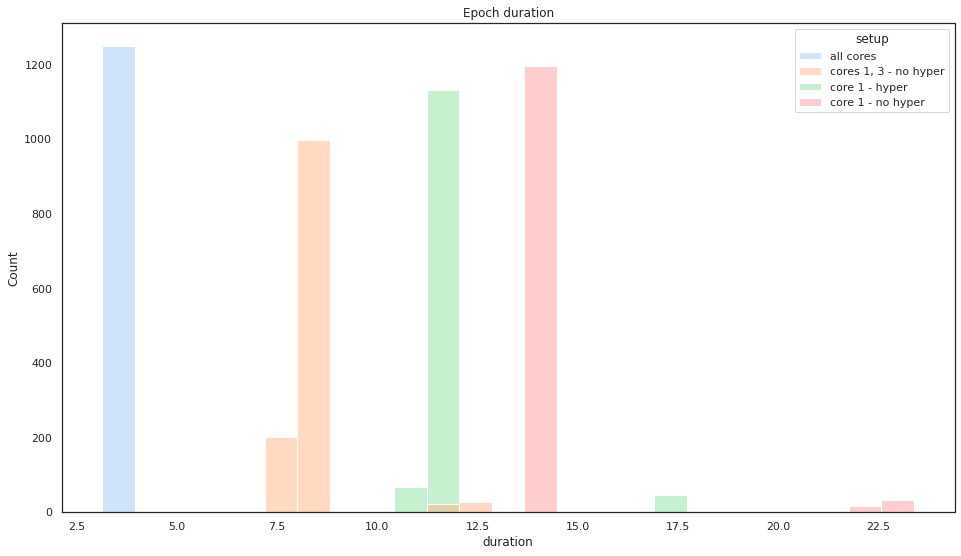

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(data=df, x='duration', hue='setup', kde=False, ax=ax)
ax.set_title('Epoch duration');

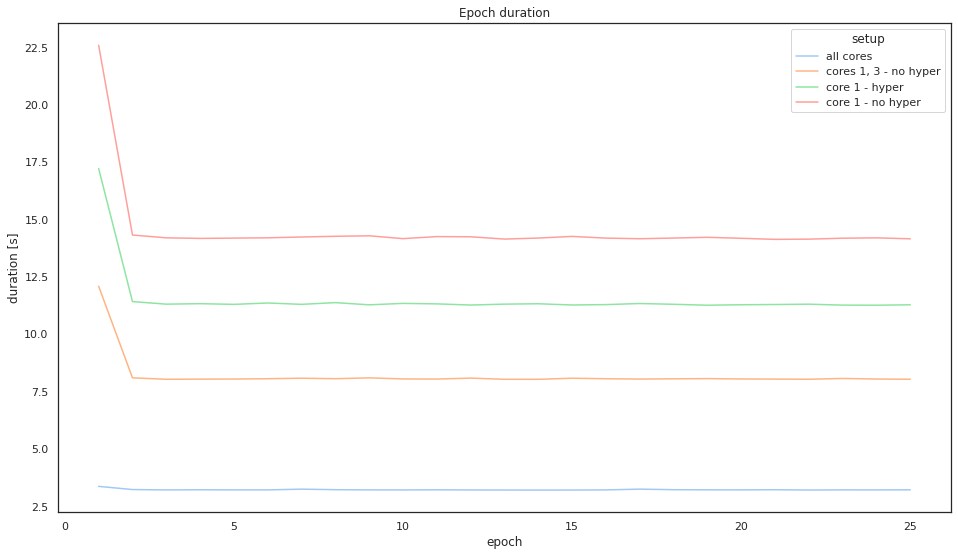

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='duration', hue='setup', ci=None, ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

The objective of this model is to achieve 94% validation accuracy in the least amount of time. The desired accuracy is reached on most runs.

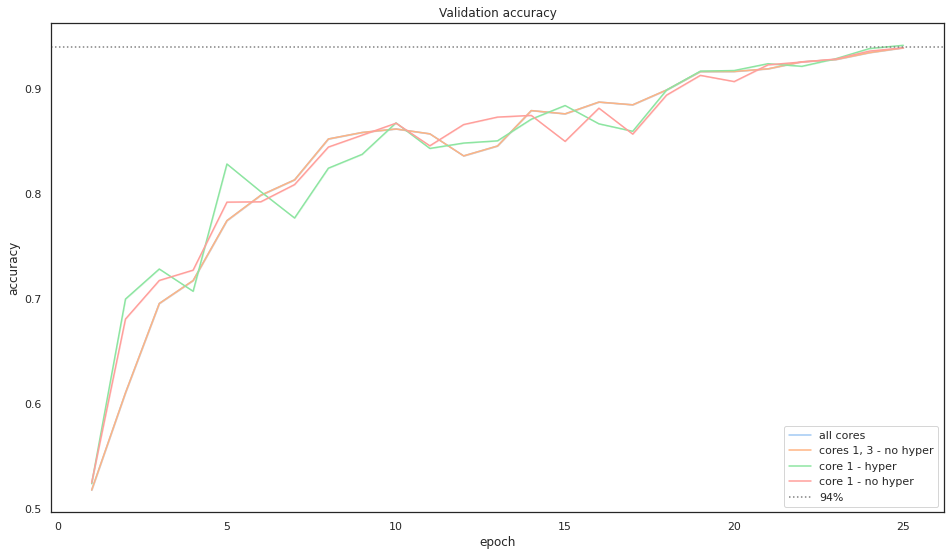

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df, x='epoch', y='valid acc', hue='setup', ax=ax)
ax.axhline(0.94, linestyle=':', color='gray', label='94%')
ax.set_ylabel('accuracy')
ax.set_title('Validation accuracy')
ax.legend();

## Energy consumption

In [10]:
df_sum_energy_setup = df.filter(regex='energy').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_package_energy_setup = df.filter(regex='(?=.*package)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')
df_sum_gpu_energy_setup = df.filter(regex='(?=.*nvidia_gpu)(?=.*energy)').sum(axis=1).groupby(level=['setup', 'run']).sum().unstack(level='setup')

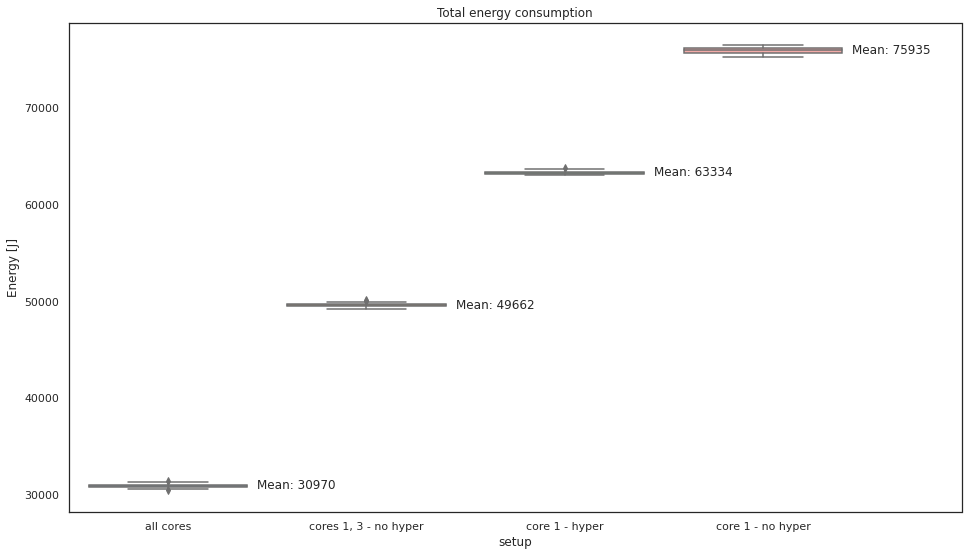

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_energy_setup, ax=ax)
ax.set_title('Total energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

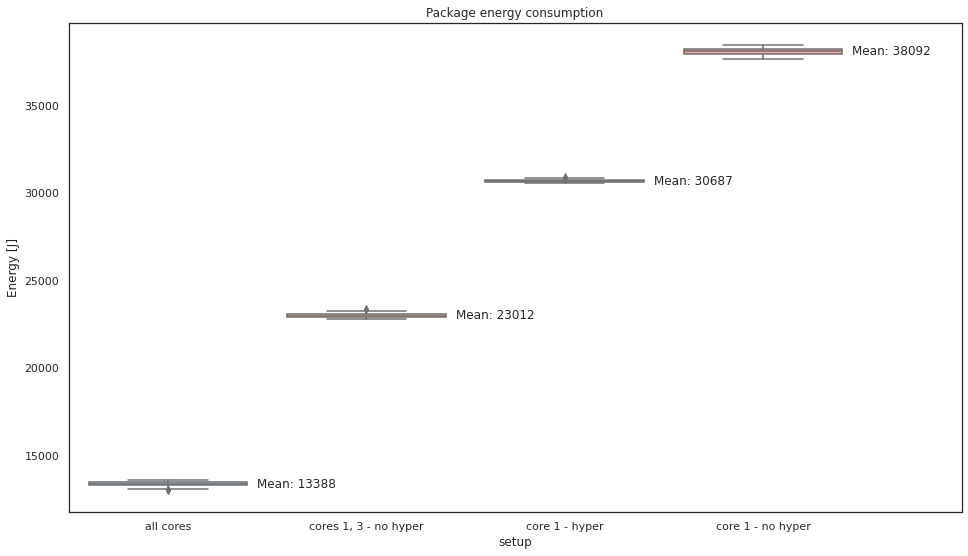

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_package_energy_setup, ax=ax)
ax.set_title('Package energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_package_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

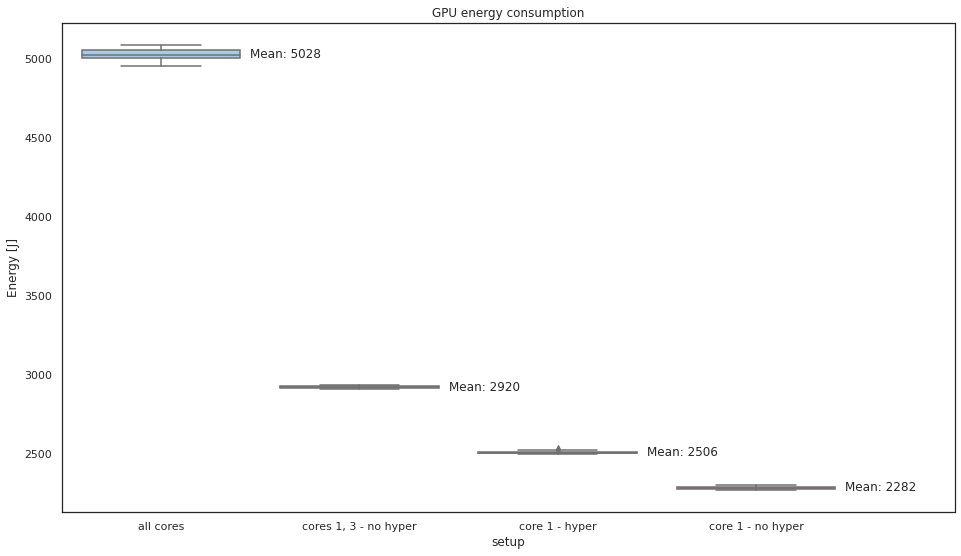

In [18]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.boxplot(data=df_sum_gpu_energy_setup, ax=ax)
ax.set_title('GPU energy consumption')
ax.set_ylabel('Energy [J]')
for x_pos, energy in zip(ax.get_xticks(), df_sum_gpu_energy_setup.mean()):
    ax.text(x_pos+0.45, energy, f'Mean: {round(energy)}', horizontalalignment='left', verticalalignment='center')
ax.set_xlim(ax.get_xticks()[0]-0.5, ax.get_xticks()[-1]+1);

## Cumulative energy consumption versus accuracy

As validation accuracy increases, the energy required for subsequent improvements grows considerably.

In [14]:
df_cum_energy_validacc_setup = df.groupby(level=['setup', 'epoch']).mean().reset_index().set_index(['setup', 'valid acc']).filter(like='energy').sum(axis=1).unstack(level='setup').cumsum().interpolate(method='index').dropna()

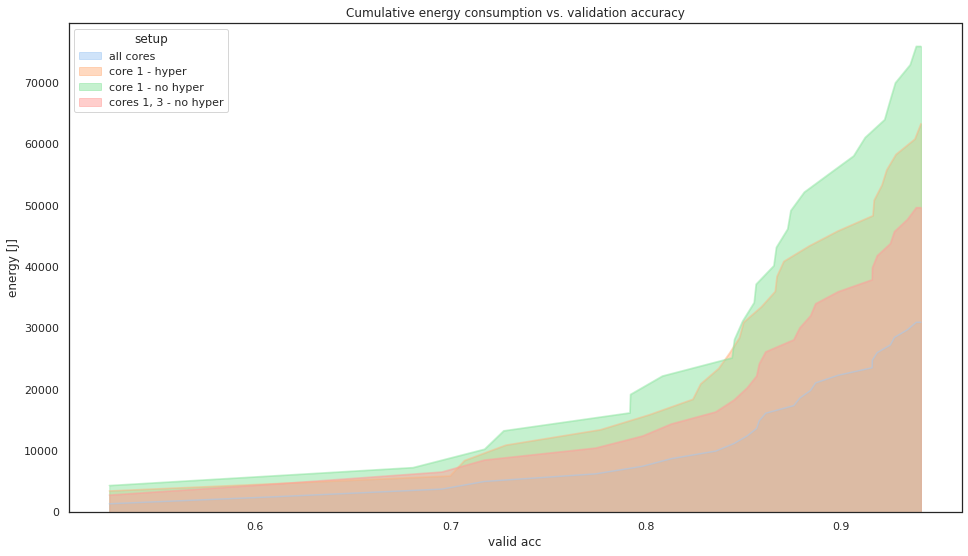

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc_setup.plot.area(ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy', stacked=False, ax=ax);

## Package power consumption

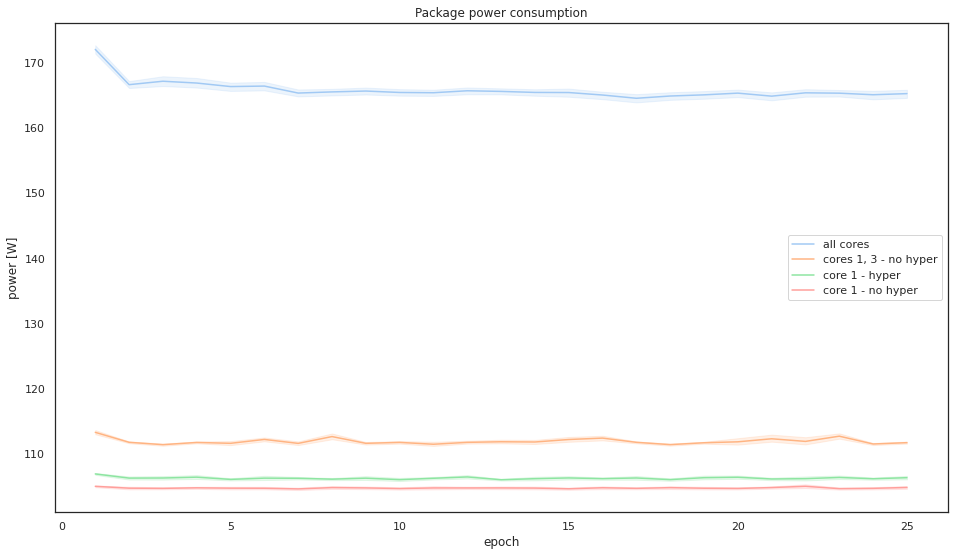

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
df['package power'] = df['package_0 power'] + df['package_1 power']
sns.lineplot(data=df, x='epoch', y='package power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('Package power consumption')
ax.legend();

## GPU power consumption

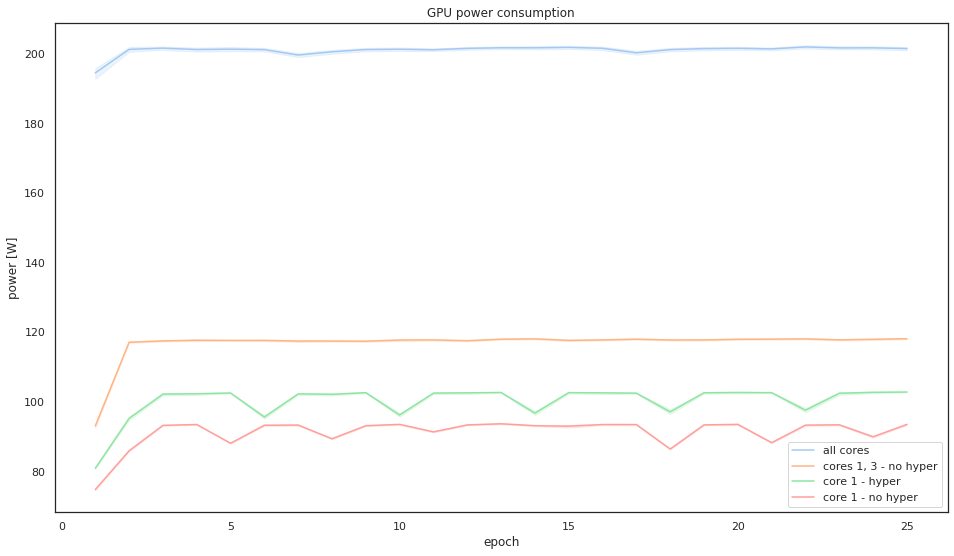

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))
df['nvidia_gpu power'] = df['nvidia_gpu_0 power'] + df['nvidia_gpu_1 power']
sns.lineplot(data=df, x='epoch', y='nvidia_gpu power', hue='setup', ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();